# Hate Crime and Facebok

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import datetime

## Basic Preprocessing of Hate Crime Data

In [2]:
hate_crime = pd.read_csv('/home3/r05322021/Desktop/FB Data/hate_crime_data/clean_data/hate_crime.csv')
hate_crime.date = pd.to_datetime(hate_crime.date)
hate_crime = hate_crime[(hate_crime.date.dt.date >= datetime.date(2015,5,3)) & (hate_crime.date.dt.date < datetime.date(2016,11,27))]
hate_crime['Week'] = hate_crime['date'].apply(lambda x: datetime.date(2015,5,3) + datetime.timedelta(days=np.floor(((x.date() - datetime.date(2015,5,3)).days)/7)*7))
hate_crime['week'] = hate_crime['date'].apply(lambda x: np.floor(((x.date() - datetime.date(2015,5,3)).days)/7) + 1)
hate_crime

,agency,year,city,population_group,country_division,country_region,agency_indicator,core_city,population,state,...,offense_type,number_of_group_victims,location,motivation,victim_type,week,month_year,month,state_name,Week
1,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,13C,1,9,12,I,29.0,2015-11,11,Alaska,2015-11-15
2,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,13C,10,20,12,I,13.0,2015-07,7,Alaska,2015-07-26
3,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,200,1,5,43,NaN,6.0,2015-06,6,Alaska,2015-06-07
4,AK0010100,2015,ANCHORAGE,1C,9,4,1,Y,301239,50,...,13A,1,13,12,I,14.0,2015-08,8,Alaska,2015-08-02
5,AK0010100,2016,ANCHORAGE,1C,9,4,1,Y,299097,50,...,13B,1,53,12,I,41.0,2016-02,2,Alaska,2016-02-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,WY0030100,2015,GILLETTE,4,8,4,1,N,32502,49,...,13B,1,13,15,I,18.0,2015-09,9,Wyoming,2015-08-30
19141,WY0030100,2015,GILLETTE,4,8,4,1,N,32502,49,...,13B,1,54,12,I,23.0,2015-10,10,Wyoming,2015-10-04
19142,WY0030100,2016,GILLETTE,4,8,4,1,N,33218,49,...,13B,2,53,32,I,55.0,2016-05,5,Wyoming,2016-05-15
19143,WY0030100,2016,GILLETTE,4,8,4,1,N,33218,49,...,13A,1,53,32,I,59.0,2016-06,6,Wyoming,2016-06-12


### Transform to State-Week Level Data

In [4]:
crime_df_list = []
Week_list = hate_crime.Week.unique().tolist()
for d in [group[1] for group in hate_crime.groupby(by='state_name')]:
    state_df = pd.DataFrame(index=Week_list, columns=['state', 'hate_crime', 'racial_crime', 'racial_broad_crime'])
    state_df.loc[:, 'state'] = d.state_name.iloc[0]
    for df in [group[1] for group in d.groupby(by=['Week'])]: 
        state_df.loc[df.Week.iloc[0], 'hate_crime'] = len(df)
        state_df.loc[df.Week.iloc[0], 'racial_crime'] = len(df[df.motivation.isin([11,12,13,14,15,24,32,33])])
        state_df.loc[df.Week.iloc[0], 'racial_broad_crime'] = len(df[df.motivation.isin([11,12,13,14,15,21,22,23,24,25,26,27,32,33])])
    crime_df_list.append(state_df.fillna(0))

In [5]:
crime_df = pd.concat(crime_df_list,axis=0)
crime_df.index.name = 'Week'
crime_df = crime_df.reset_index(drop=False)
crime_df['Week'] = crime_df.Week.astype(str)
crime_df.describe()

,hate_crime,racial_crime,racial_broad_crime
count,4018.000000,4018.000000,4018.000000
mean,2.365854,1.458686,1.800896
std,3.728868,2.323139,2.873341
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,3.000000,2.000000,2.000000
max,42.000000,25.000000,28.000000


## Merge with Reaction and User Data

### Reaction and User Data Preprocessing

In [13]:
reaction = pd.read_csv('/home3/r05322021/Desktop/FB Data/issue_reaction/state/reaction_weekly.csv', index_col=0)
user = pd.read_csv('/home3/r05322021/Desktop/FB Data/issue_reaction/state/user_weekly.csv', index_col=0)
reaction = reaction[reaction.Week < '2016-11-27']
user = user[user.Week < '2016-11-27']

In [22]:
reaction_immigration = reaction[reaction.type == 'immigration'][['Week', 'state', 'amount', 'ratio']].rename(columns={'amount': 'immigration_reaction_amount', 'ratio': 'immigration_reaction_ratio'})
reaction_race = reaction[reaction.type == 'race'][['Week', 'state', 'amount', 'ratio']].rename(columns={'amount': 'race_reaction_amount', 'ratio': 'race_reaction_ratio'})
user_immigration = user[user.type == 'immigration'][['Week', 'state', 'amount', 'ratio']].rename(columns={'amount': 'immigration_user_amount', 'ratio': 'immigration_user_ratio'})
user_race = user[user.type == 'race'][['Week', 'state', 'amount', 'ratio']].rename(columns={'amount': 'race_user_amount', 'ratio': 'race_user_ratio'})

In [26]:
FB_df = pd.merge(reaction_immigration, reaction_race, how='inner', on=['Week', 'state'])
for d in [user_immigration, user_race]:
    FB_df = pd.merge(FB_df, d, how='inner', on=['Week', 'state'])
for col in ['reaction_amount', 'reaction_ratio', 'user_amount', 'user_ratio']:
    FB_df[f'related_{col}'] = FB_df[f'immigration_{col}'] + FB_df[f'race_{col}']

### Merge

In [28]:
state_df = pd.merge(FB_df, crime_df, how='inner', on=['Week', 'state'])
state_df = state_df.fillna(0)
state_df.describe()

,immigration_reaction_amount,immigration_reaction_ratio,race_reaction_amount,race_reaction_ratio,immigration_user_amount,immigration_user_ratio,race_user_amount,race_user_ratio,related_reaction_amount,related_reaction_ratio,related_user_amount,related_user_ratio,hate_crime,racial_crime,racial_broad_crime
count,4.018000e+03,4018.000000,4.018000e+03,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4.018000e+03,4018.000000,4.018000e+03,4018.000000,4018.000000,4018.000000,4018.000000
mean,4.674653e+04,0.028313,3.453336e+04,0.019713,21432.364360,0.120065,17974.121453,0.093479,8.127989e+04,0.048026,3.940649e+04,0.213544,2.365854,1.458686,1.800896
std,1.152770e+05,0.018749,7.744375e+04,0.012611,47691.036759,0.066956,38490.989227,0.048997,1.714131e+05,0.021135,8.045652e+04,0.089495,3.728868,2.323139,2.873341
min,4.500000e+01,0.002716,7.700000e+01,0.002824,37.000000,0.006387,59.000000,0.009182,1.440000e+02,0.007438,1.080000e+02,0.019894,0.000000,0.000000,0.000000
25%,2.818500e+03,0.015805,1.923000e+03,0.011718,1489.000000,0.073054,1144.750000,0.059311,5.151250e+03,0.033147,2.751250e+03,0.149379,0.000000,0.000000,0.000000
50%,1.011700e+04,0.023718,7.226500e+03,0.016220,5222.500000,0.105603,4274.000000,0.082249,1.920700e+04,0.044195,1.019550e+04,0.199281,1.000000,1.000000,1.000000
75%,3.895650e+04,0.035156,2.673850e+04,0.023512,18264.500000,0.154042,14303.250000,0.115408,6.553050e+04,0.058338,3.182000e+04,0.262727,3.000000,2.000000,2.000000
max,2.246837e+06,0.141389,1.215253e+06,0.112226,829925.000000,0.461490,501400.000000,0.386057,2.544982e+06,0.159128,1.113009e+06,0.578334,42.000000,25.000000,28.000000


## Plot Relationship

In [50]:
def plot_relation(df, x_col, y_col, plot_title, save_path, y_lag=False, take_log_x=True, take_log_y=True):
    plt.figure(figsize=(10,10))
    
    if y_lag:
        x_axis = df[x_col].iloc[:-1]
        y_axis = df[y_col].iloc[1:].reset_index(drop=True)
    else:
        x_axis = df[x_col]
        y_axis = df[y_col]
    if take_log_x:
        x_axis = np.log(x_axis)
        x_col = f'log({x_col})'
    if take_log_y:
        y_axis = np.log(y_axis)
        y_col = f'log({y_col})'
    ax = sns.regplot(x=x_axis, y=y_axis)
    ax.set(xlabel=x_col, ylabel=y_col)
    ax.set_title(plot_title)
#     for item in ax.get_xticklabels():
#         item.set_rotation(45)
    plt.savefig(save_path)
    plt.show()

### No Lag

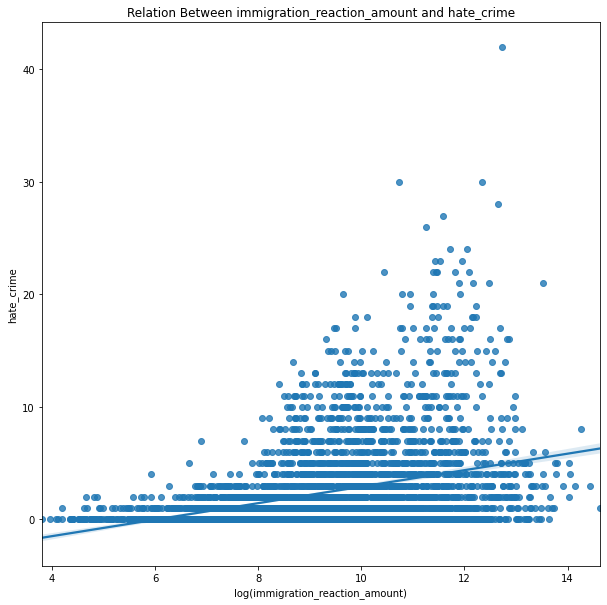

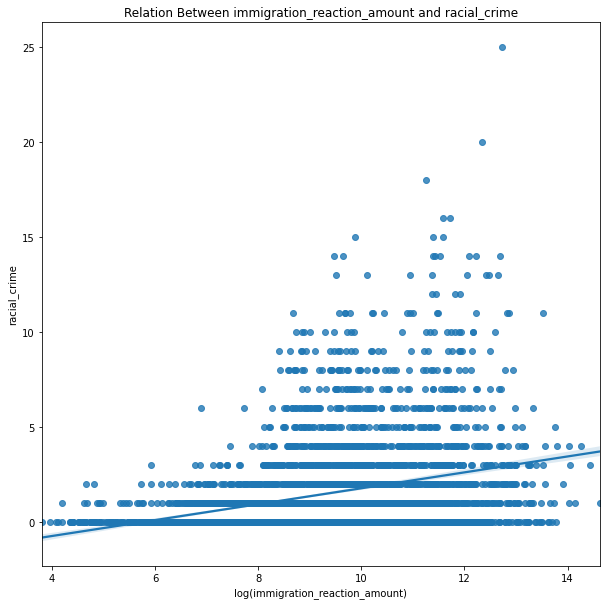

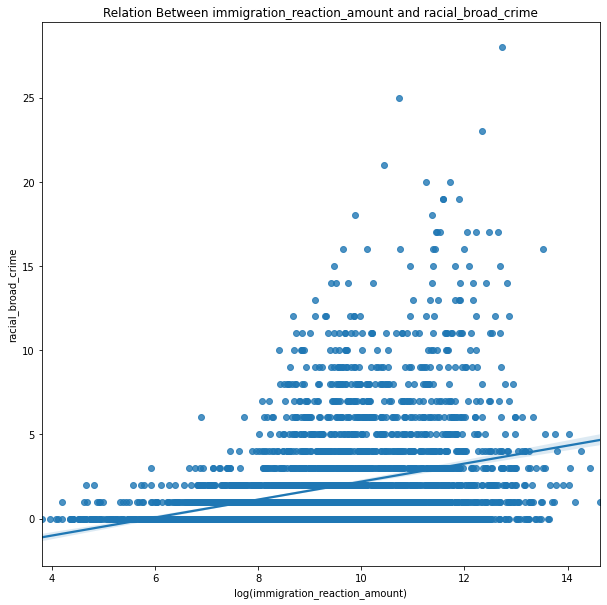

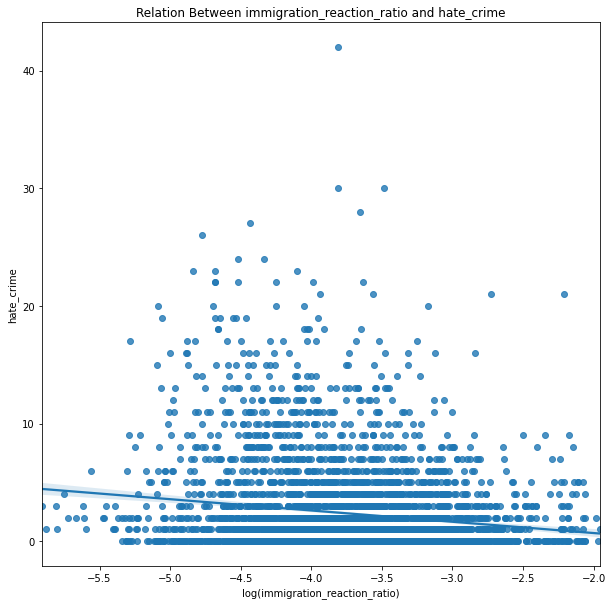

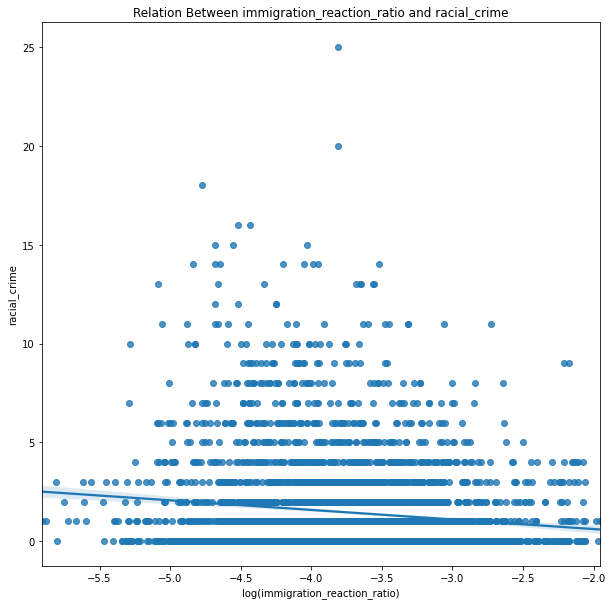

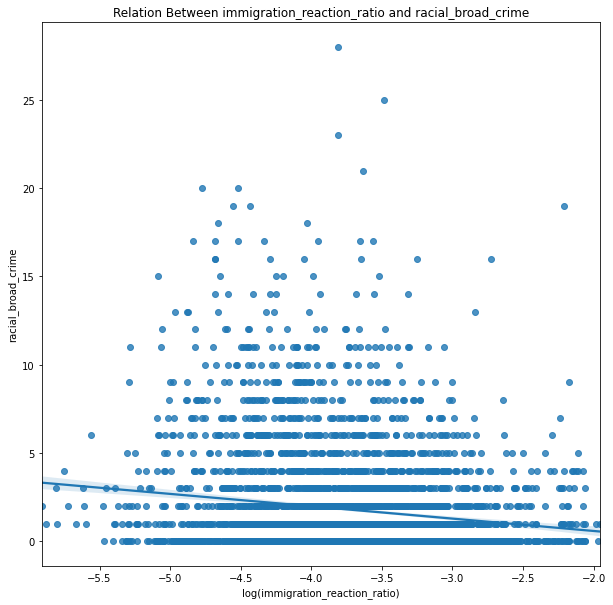

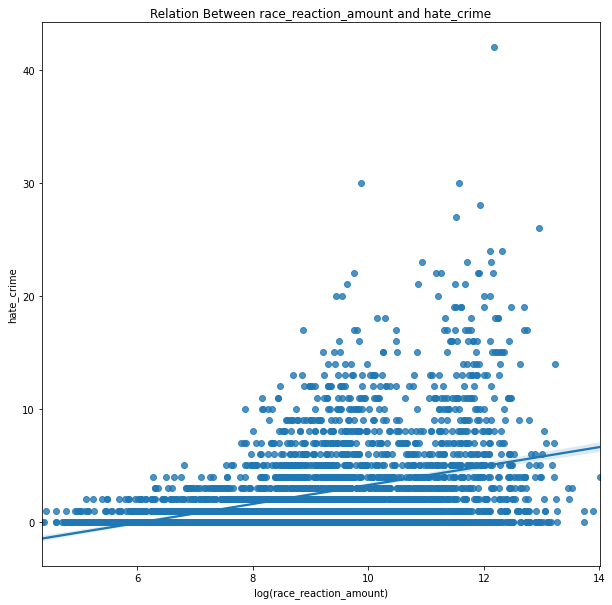

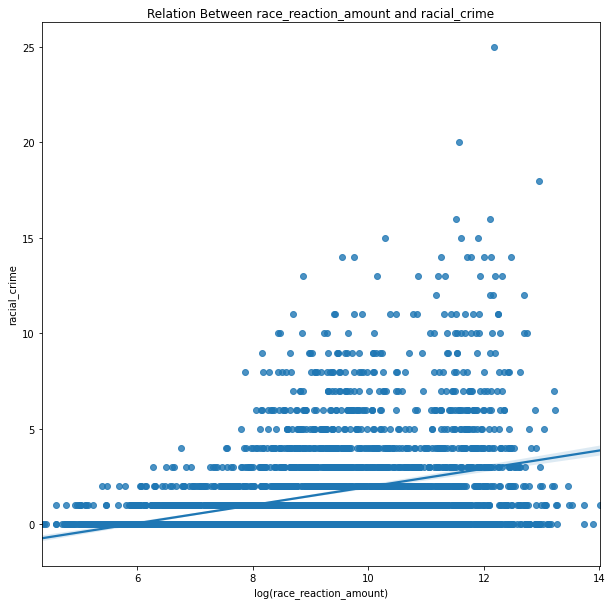

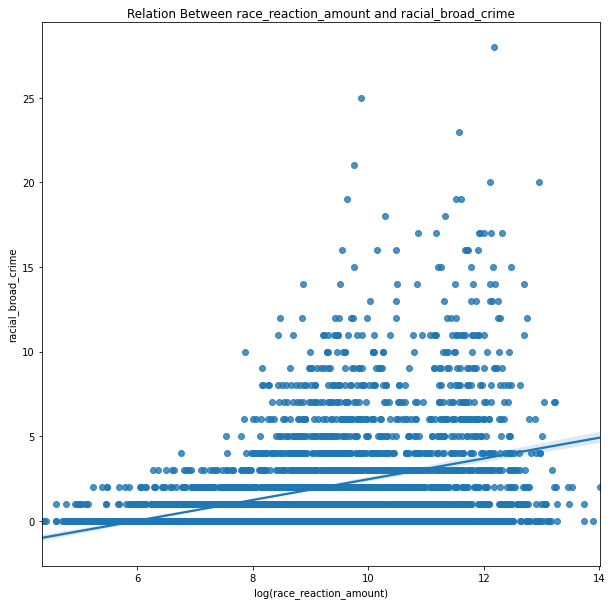

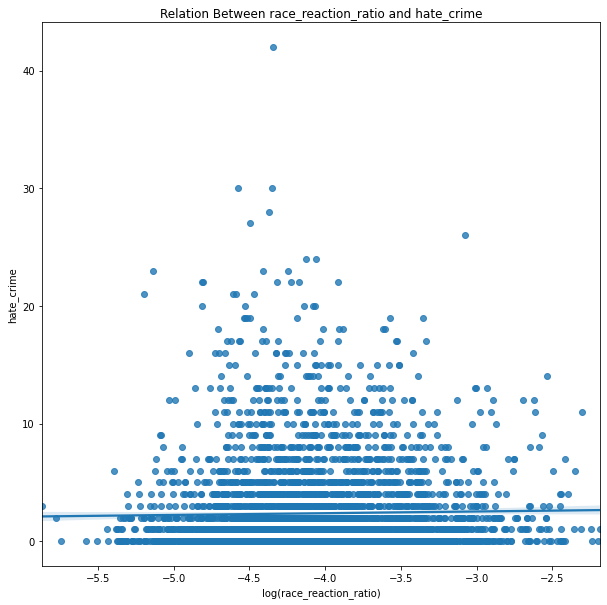

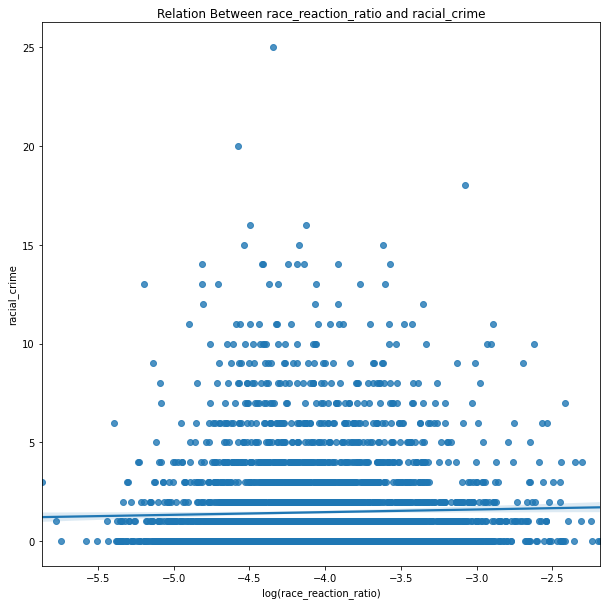

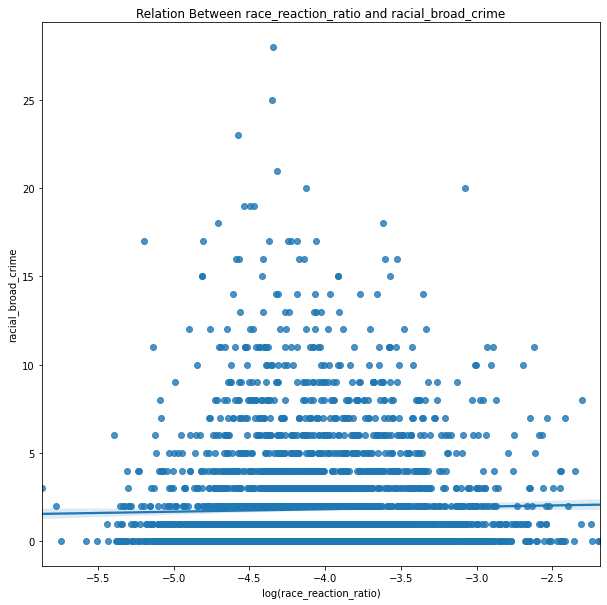

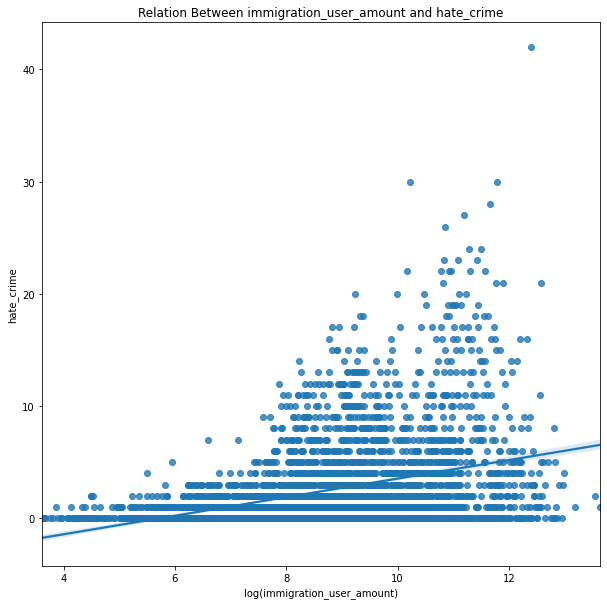

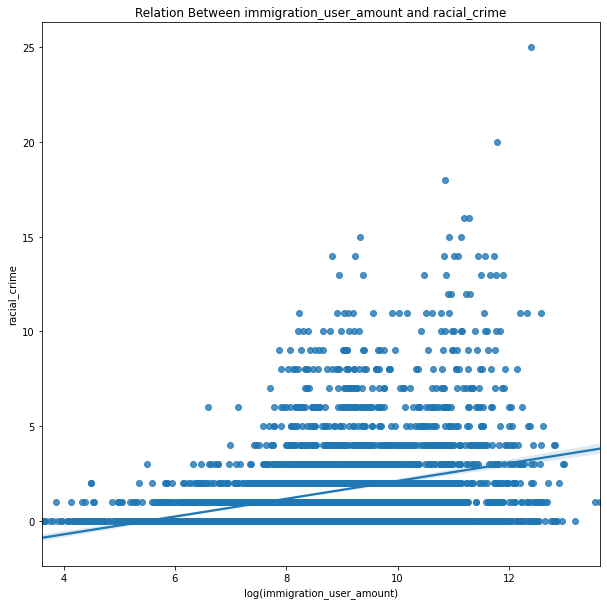

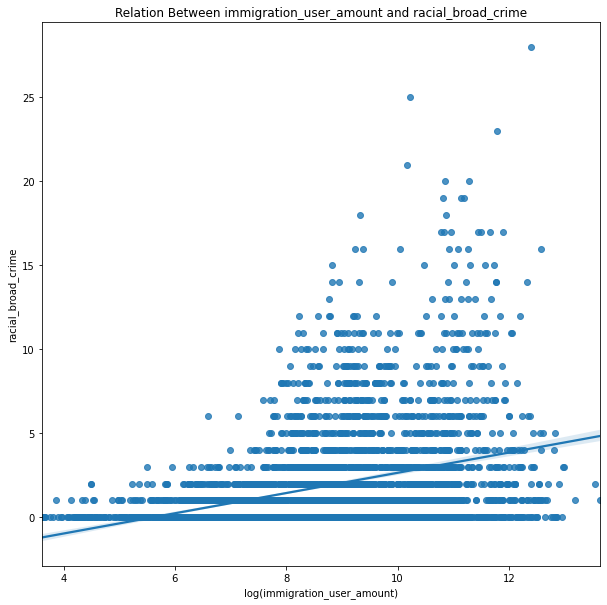

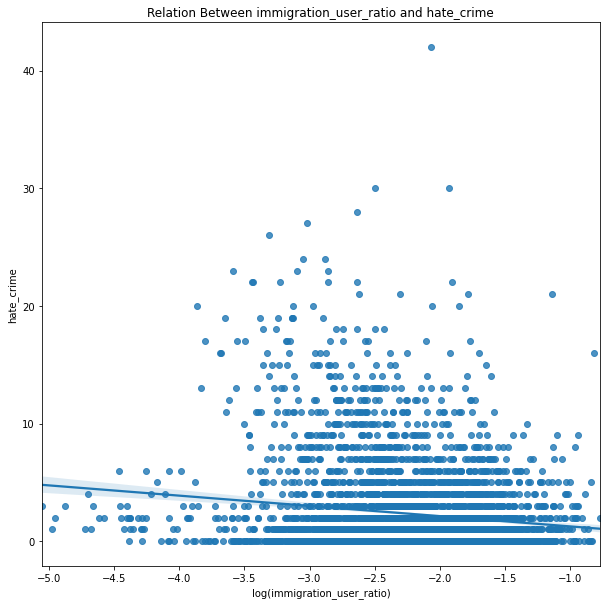

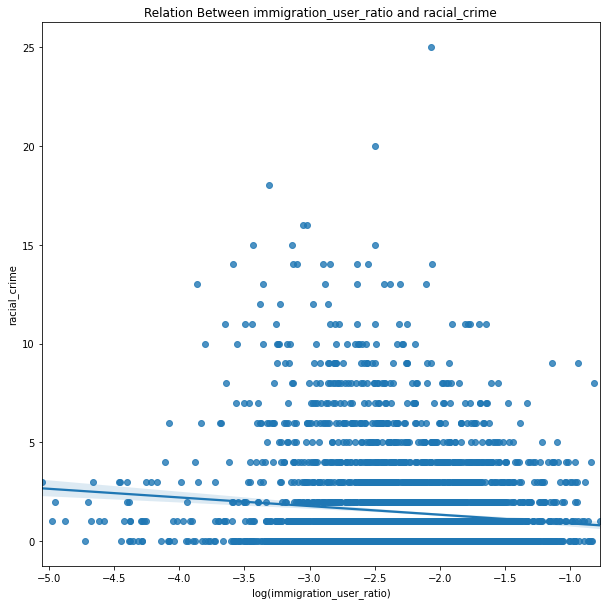

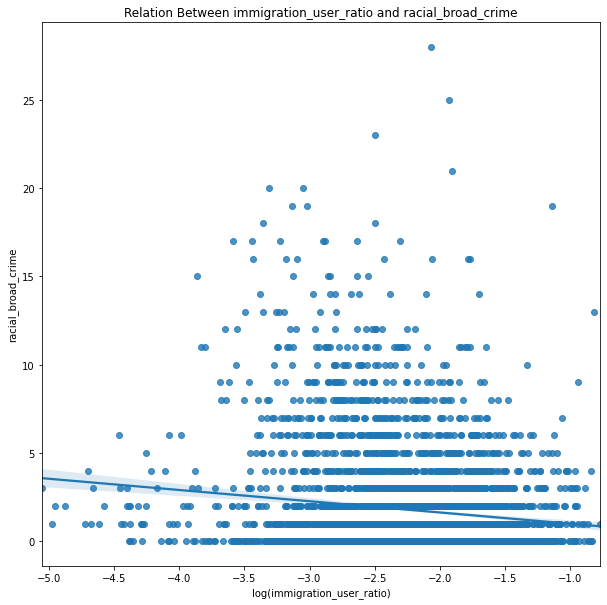

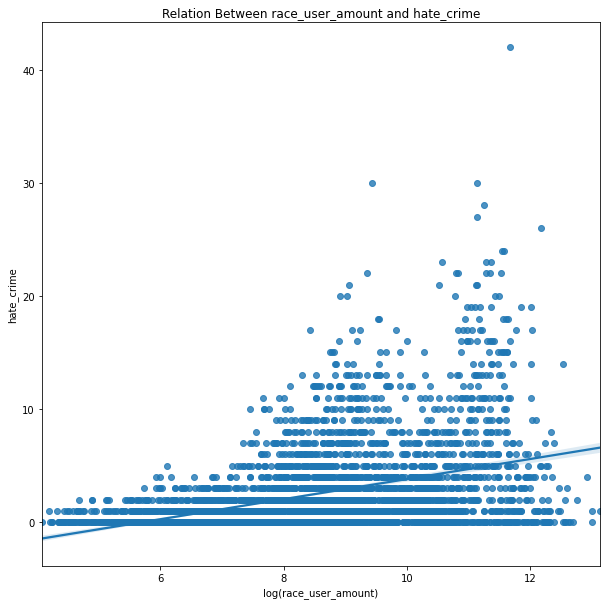

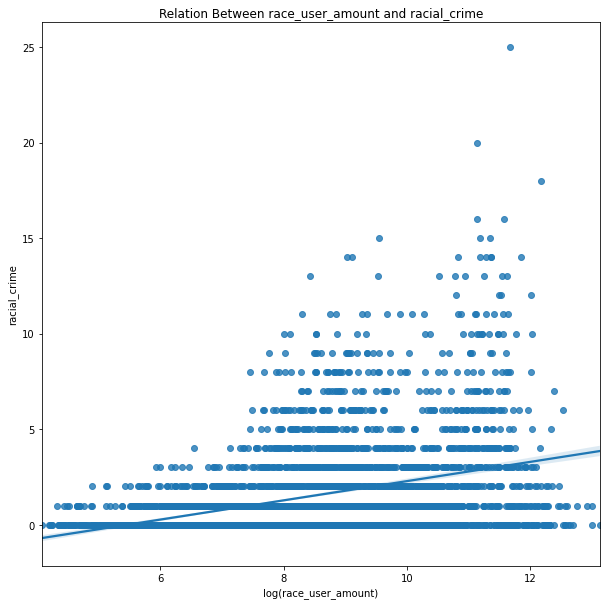

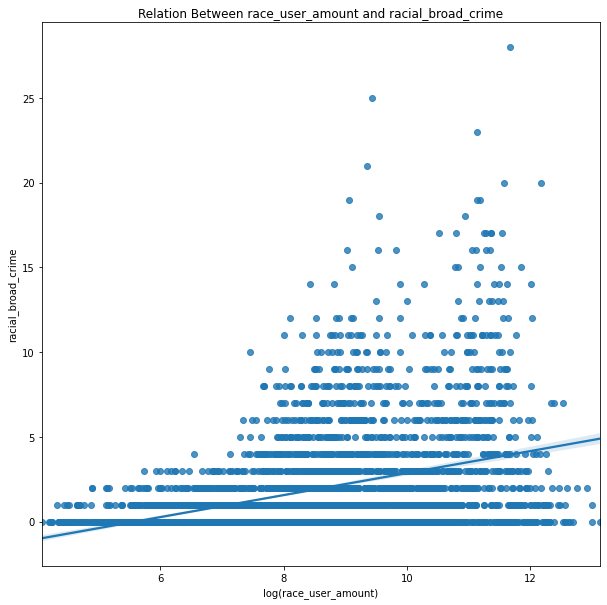

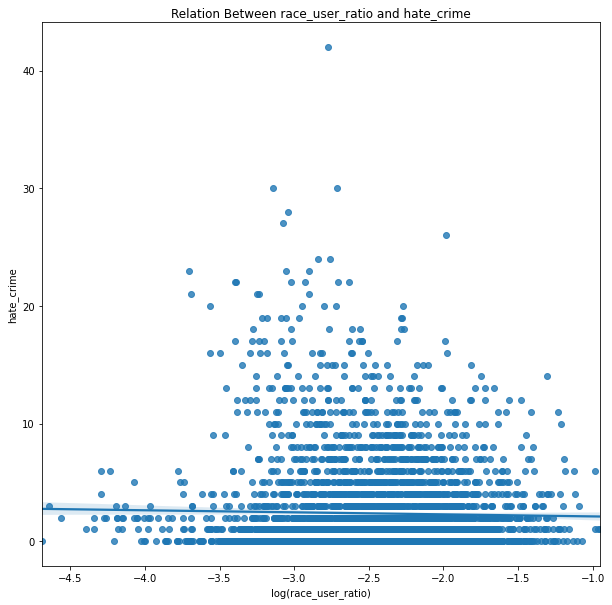

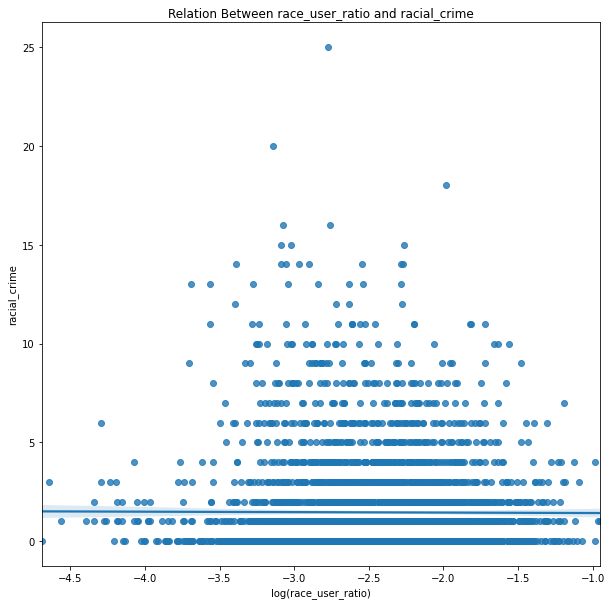

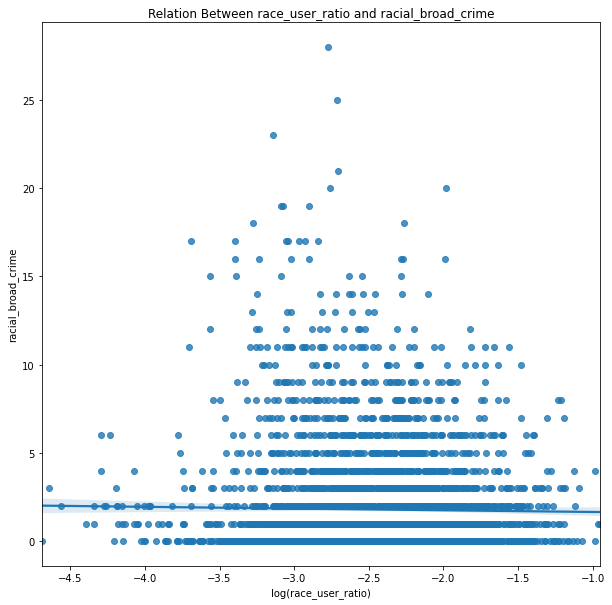

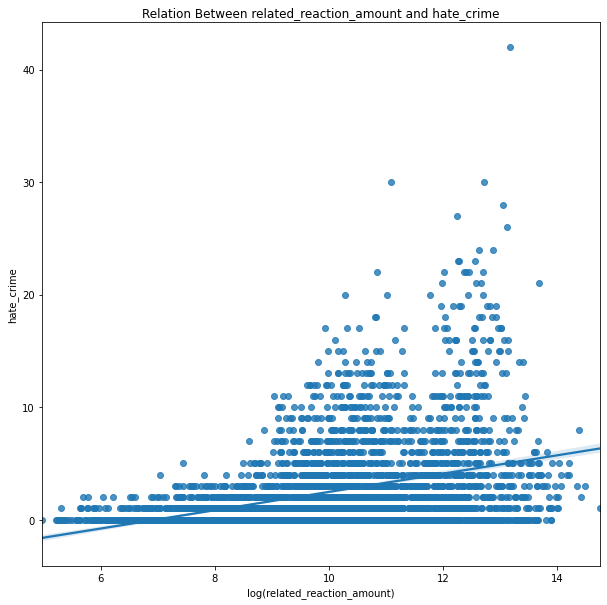

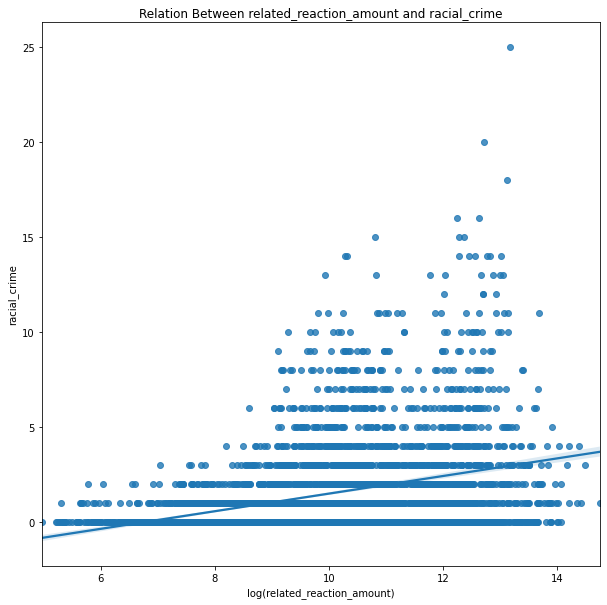

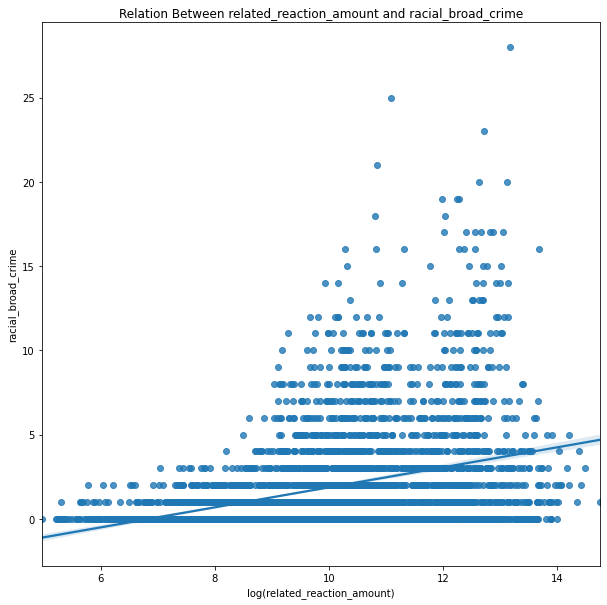

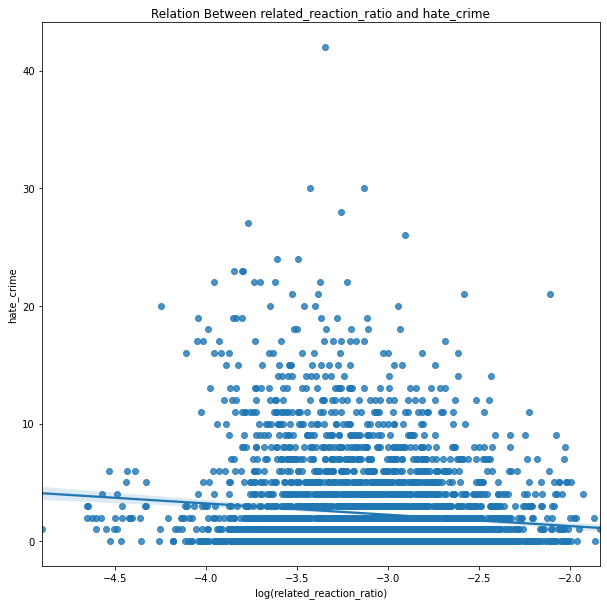

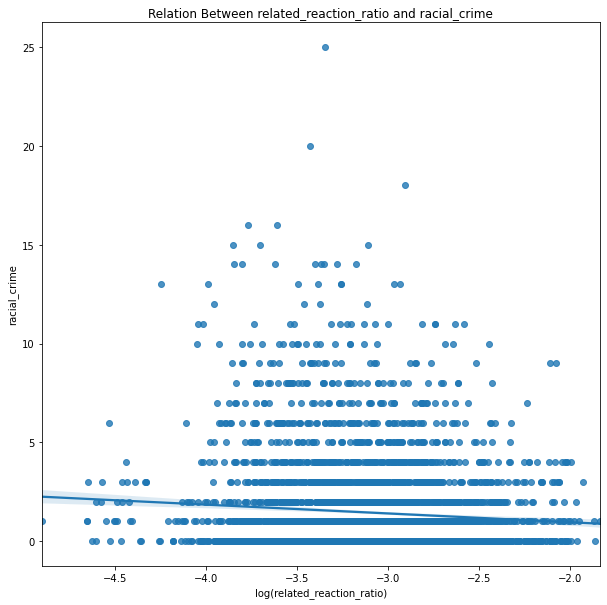

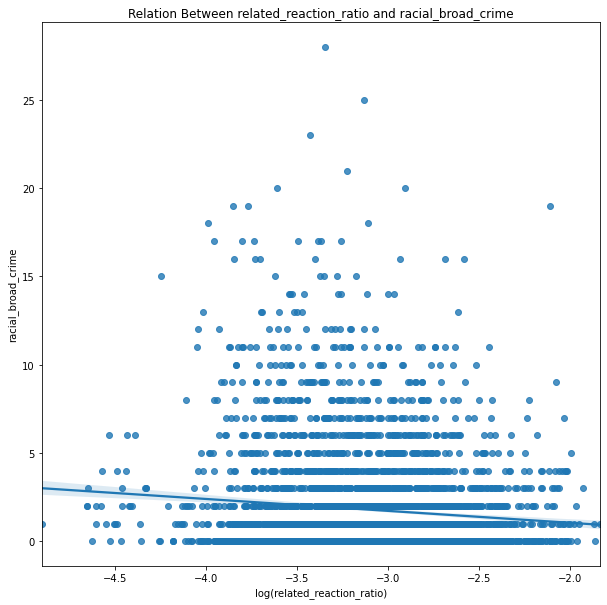

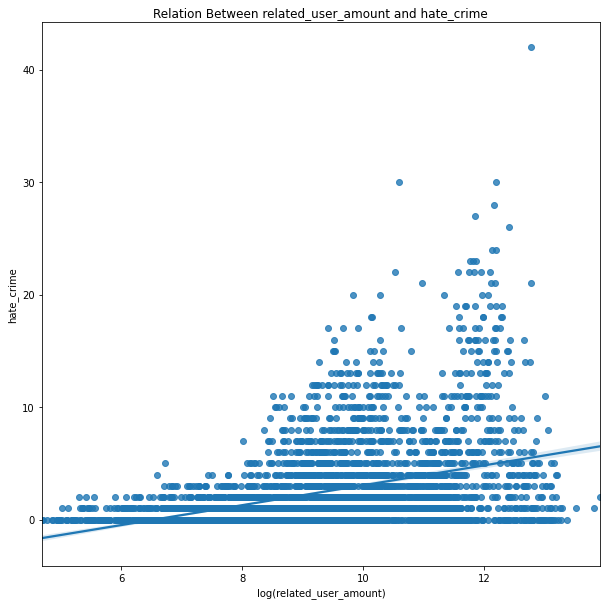

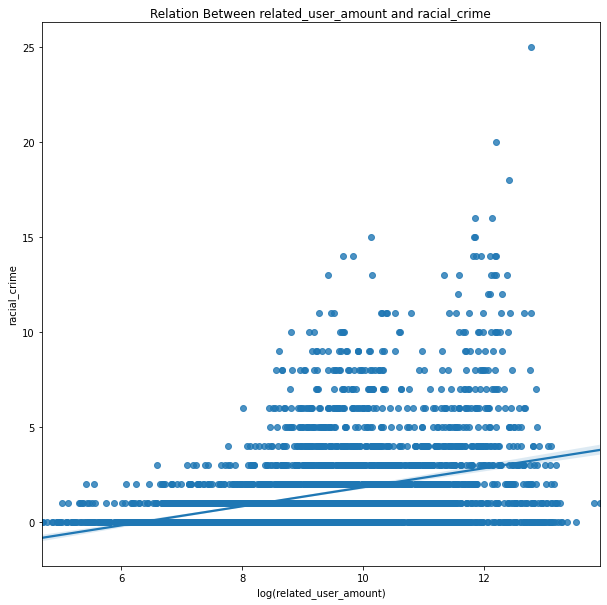

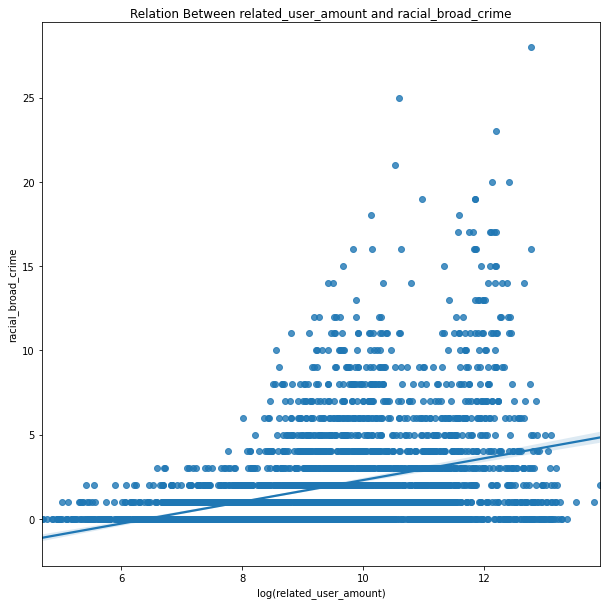

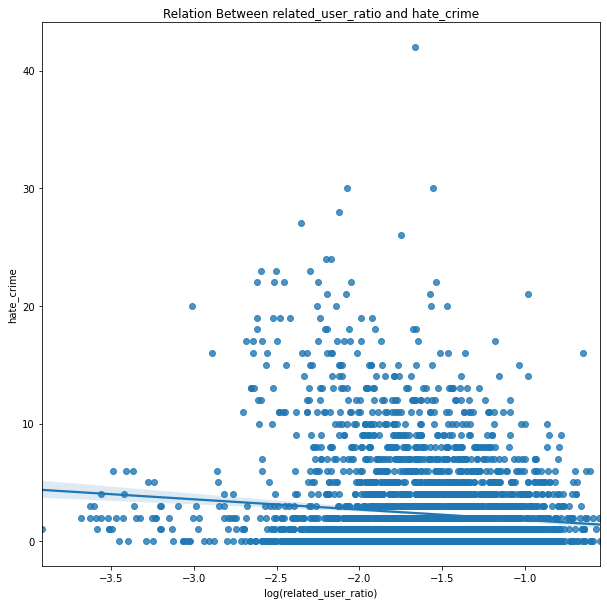

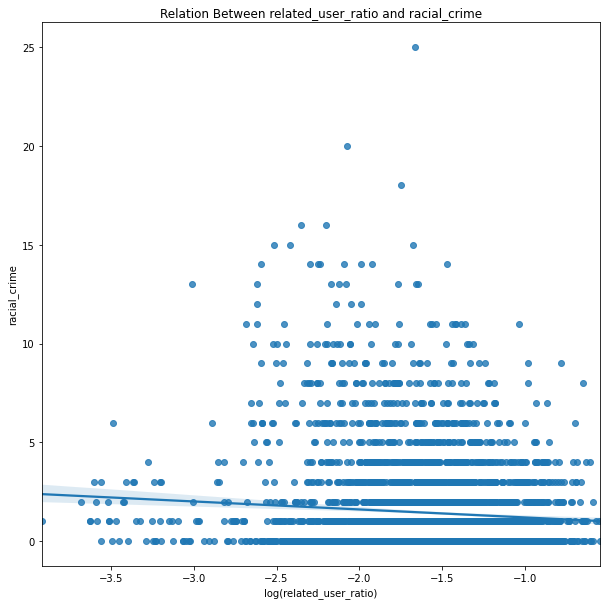

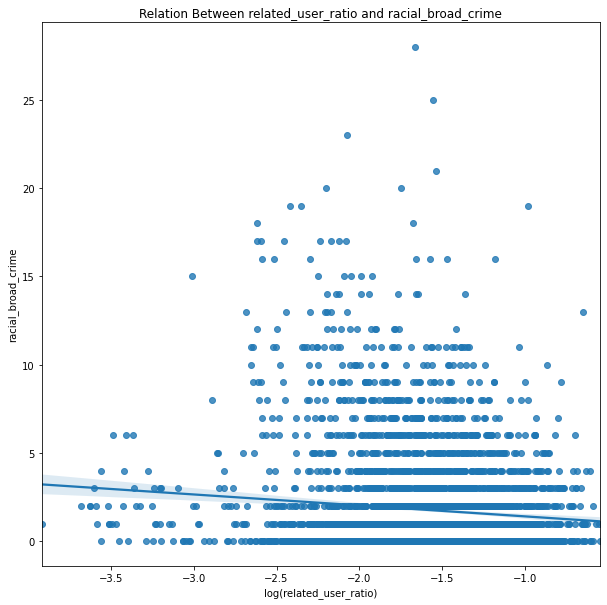

In [43]:
for x in state_df.columns[2:-3].tolist():
    for y in state_df.columns[-3:].tolist():
        plot_relation(state_df, x, y, f'Relation Between {x} and {y}', save_path=f'/home3/r05322021/Desktop/FB_hatecrime/Plot/Hate Crime/{y}/current/{x}.pdf', take_log_y=False)

### Lag

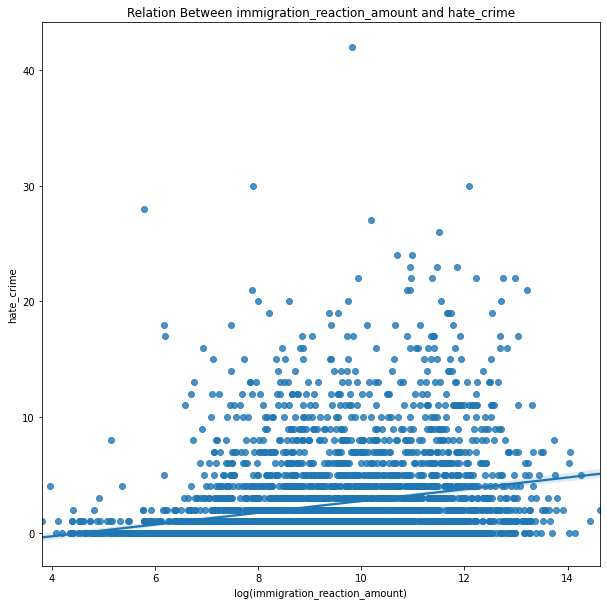

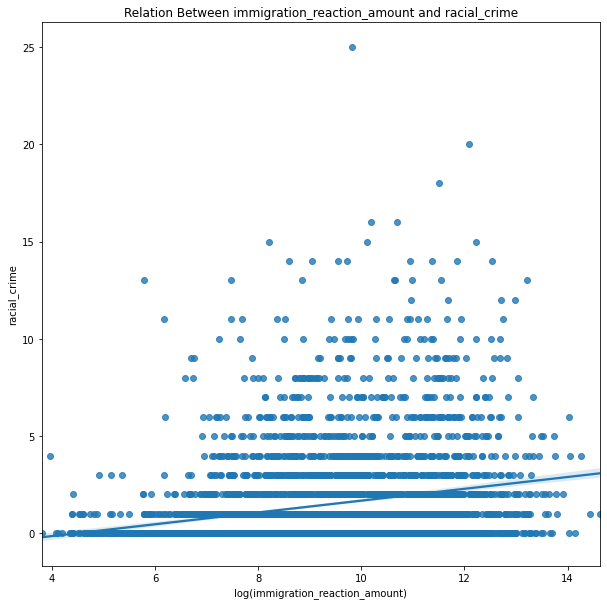

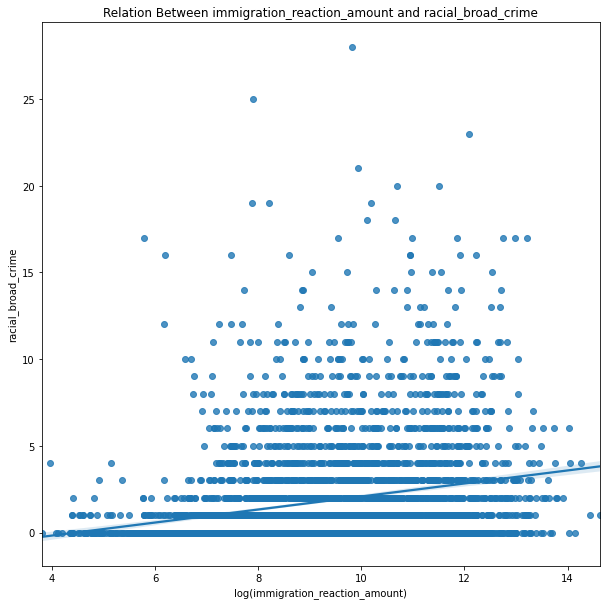

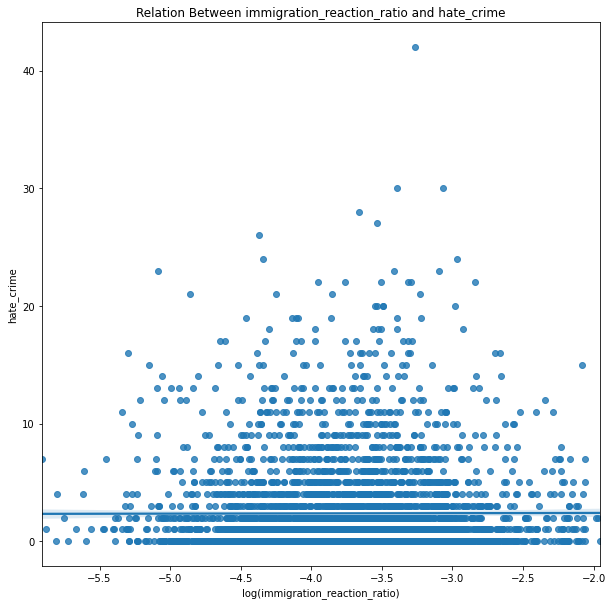

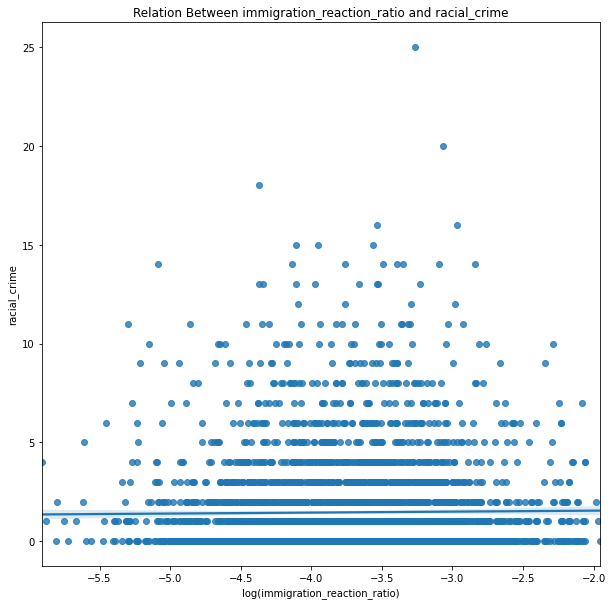

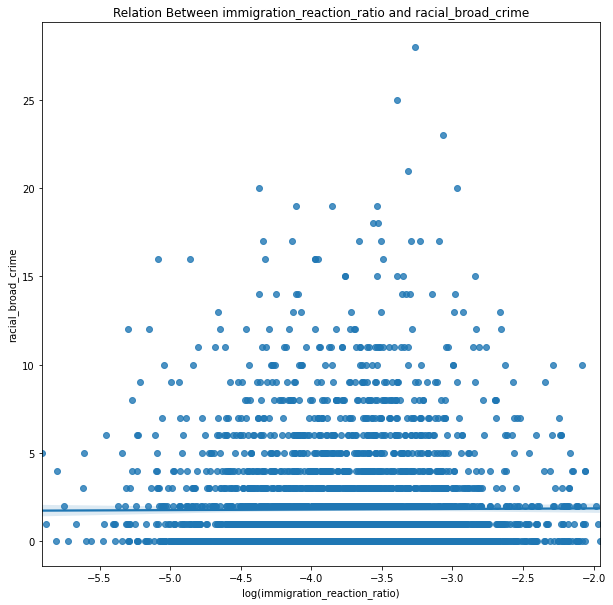

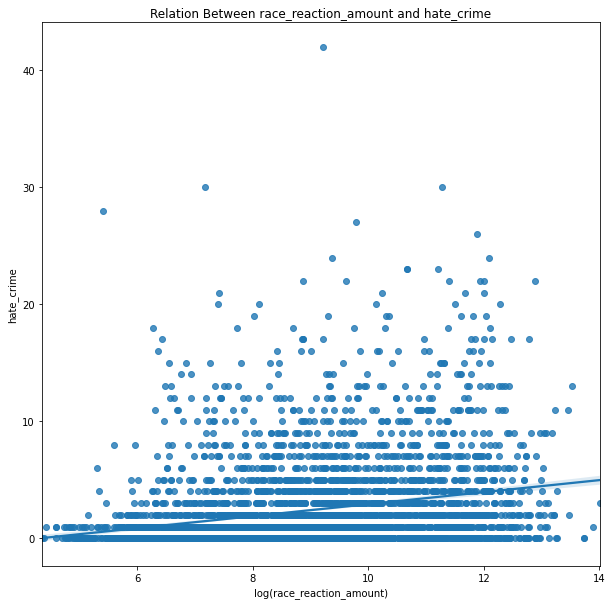

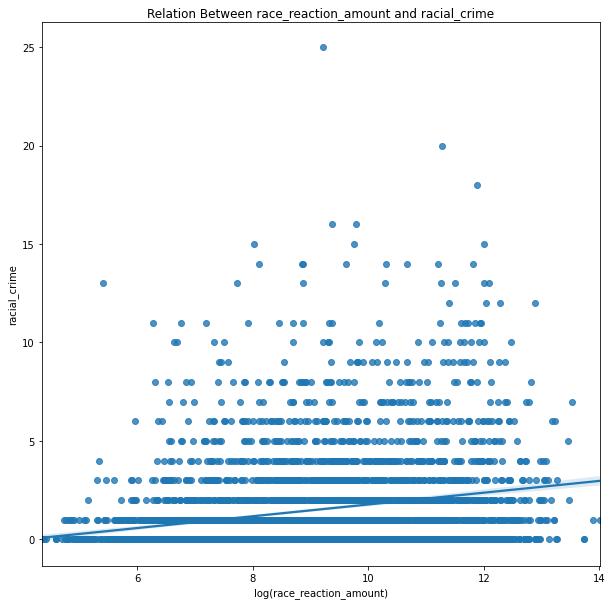

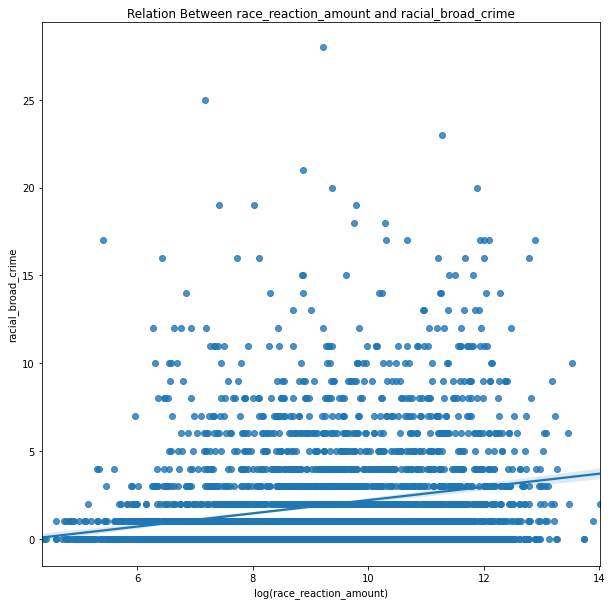

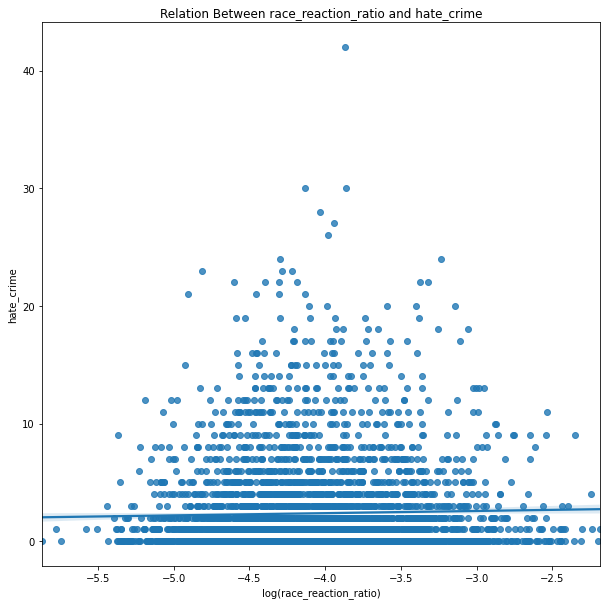

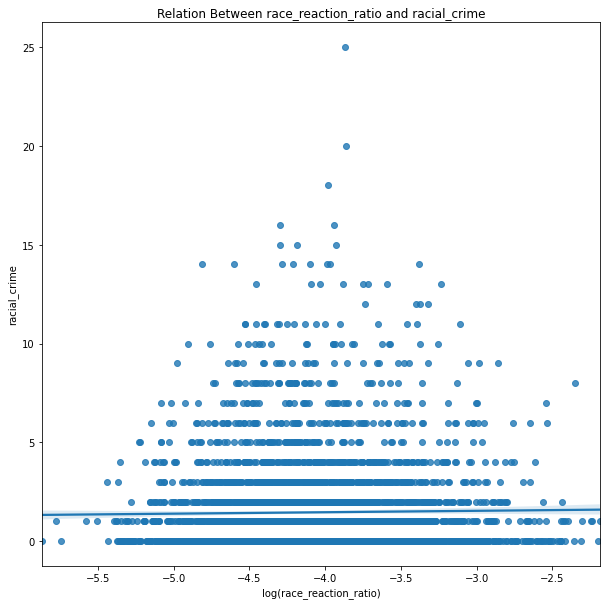

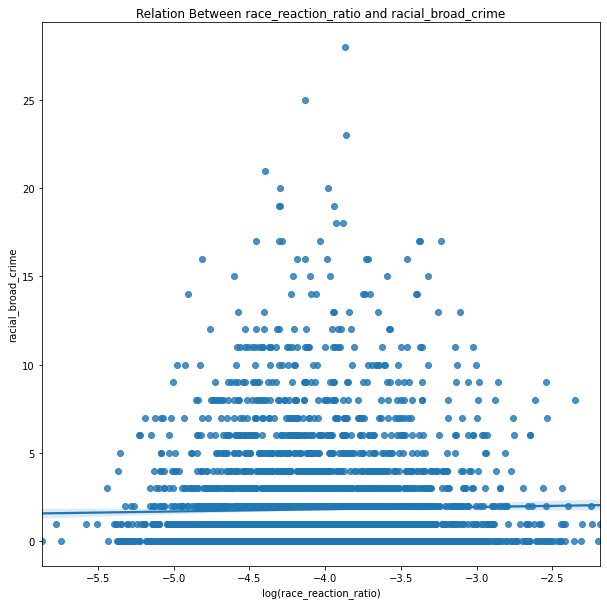

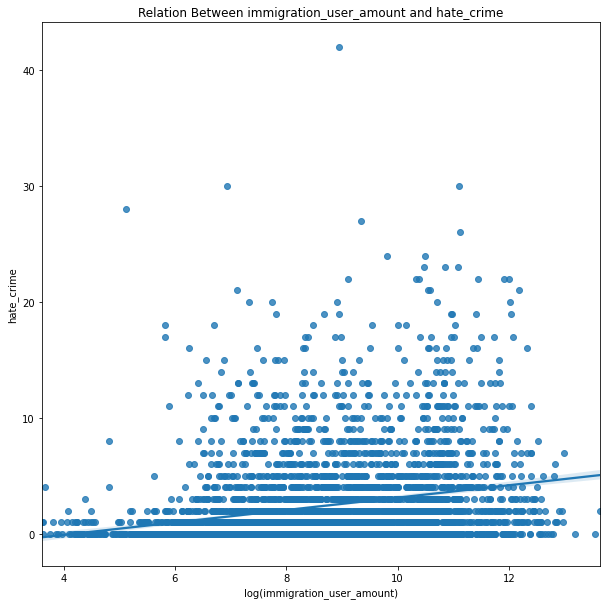

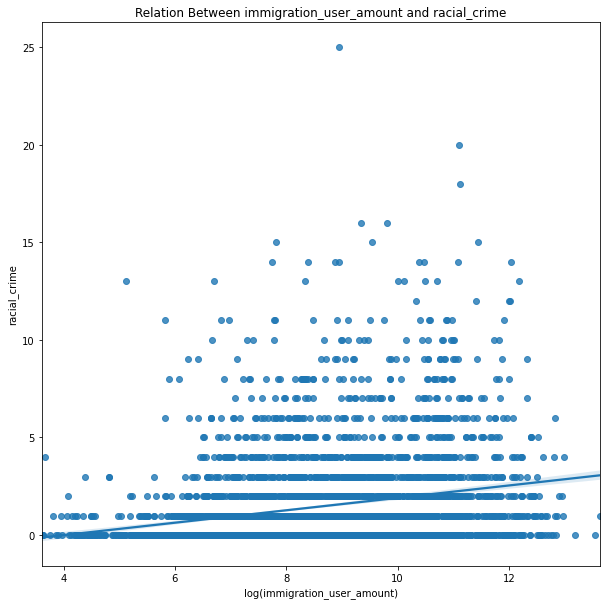

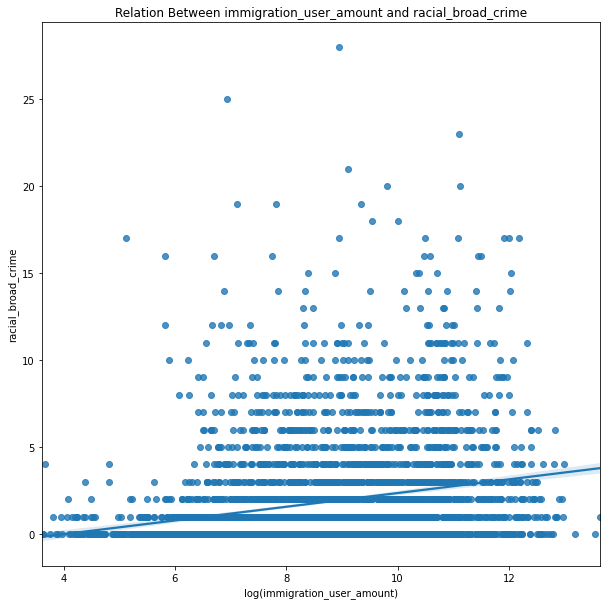

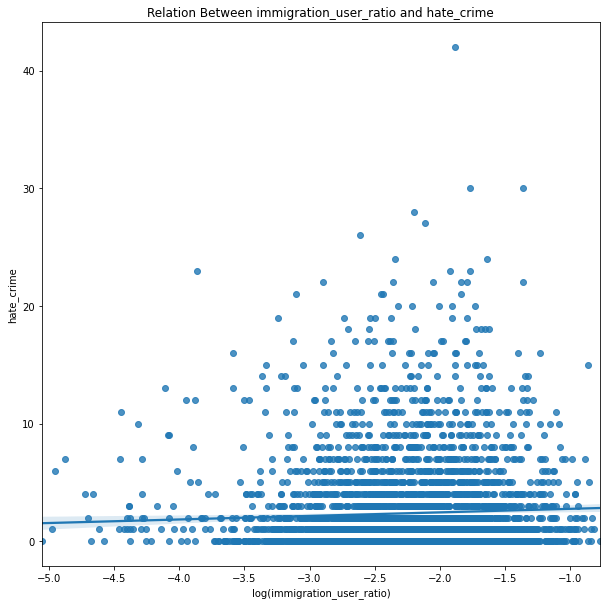

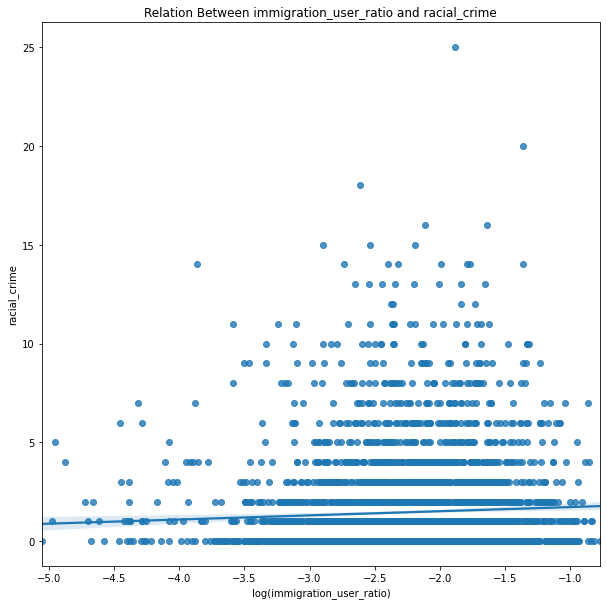

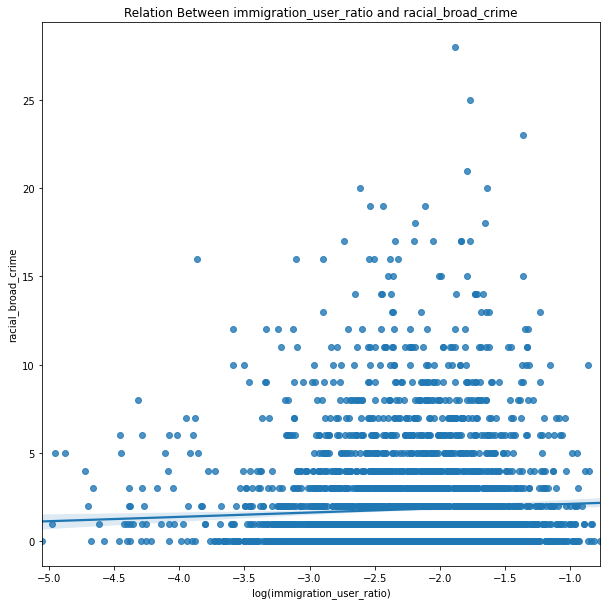

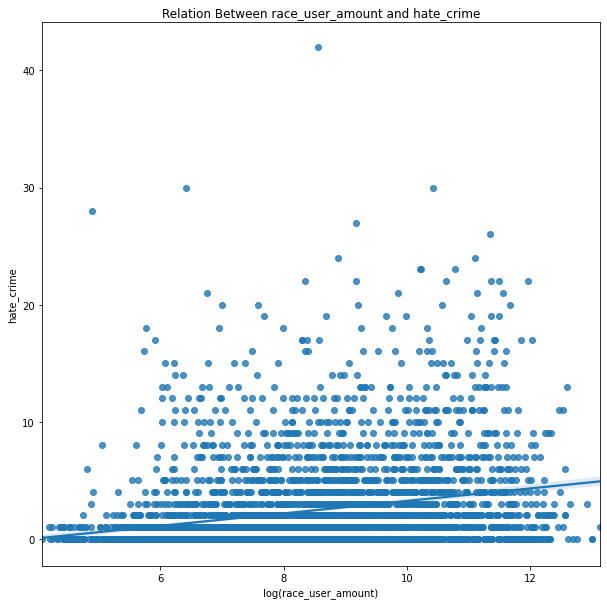

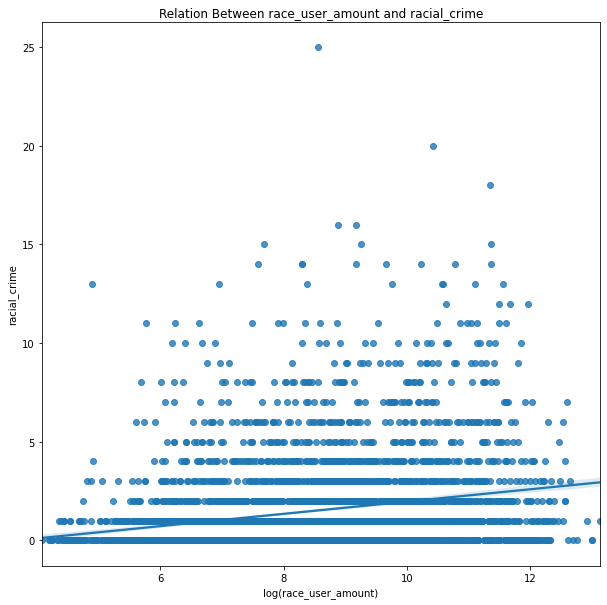

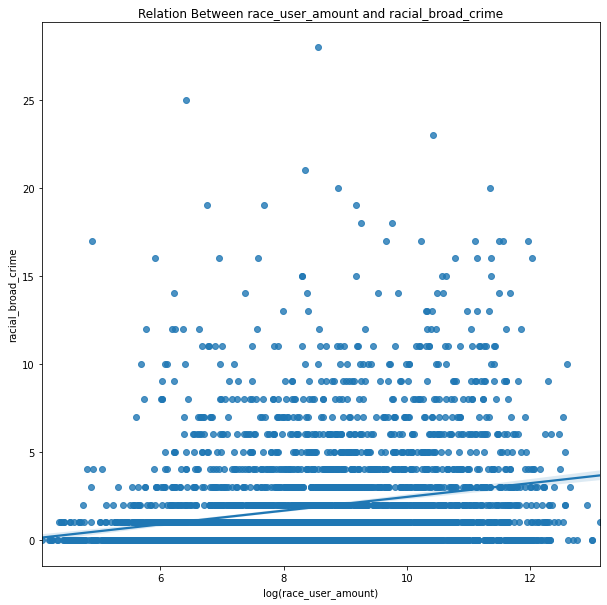

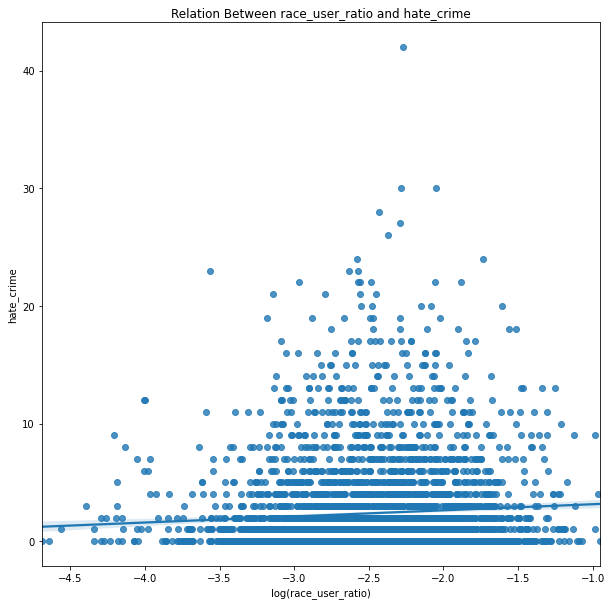

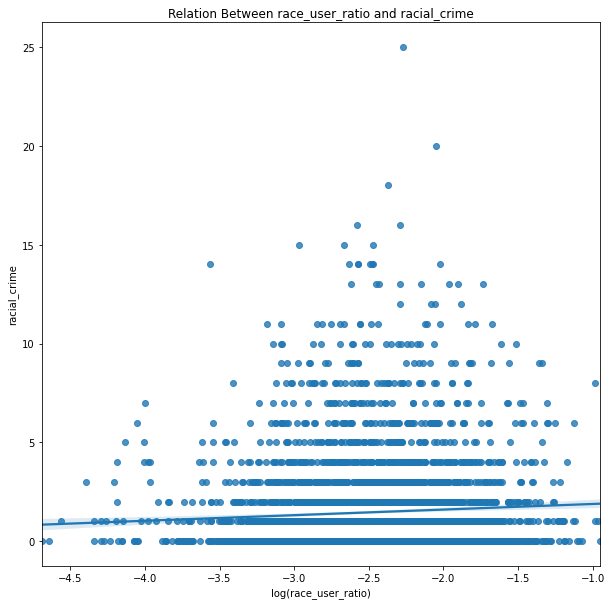

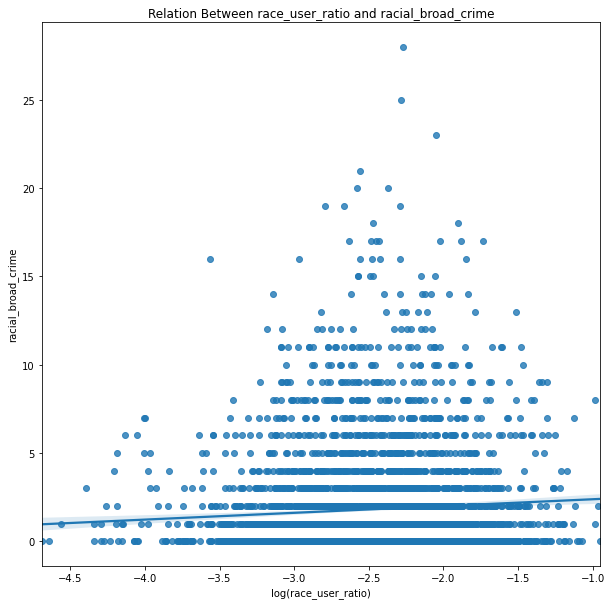

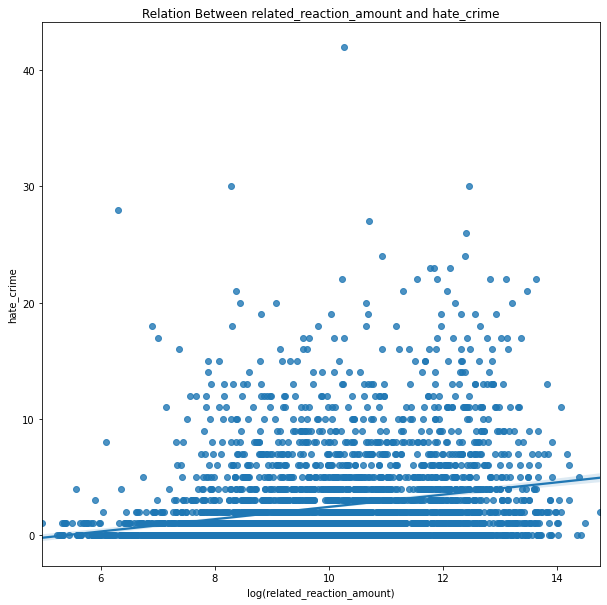

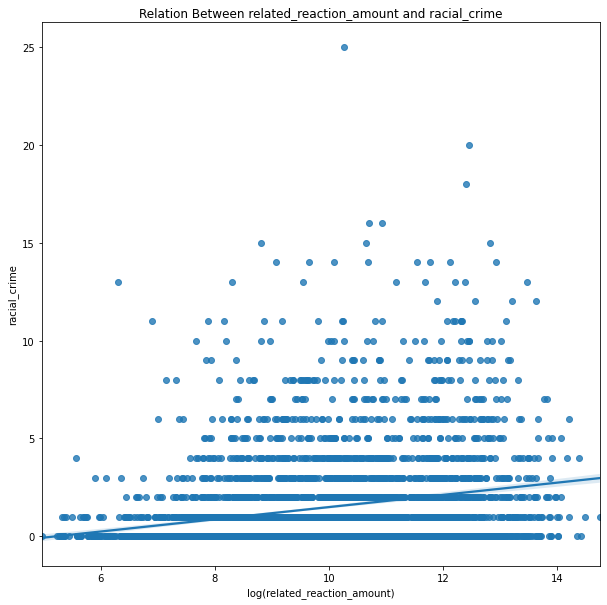

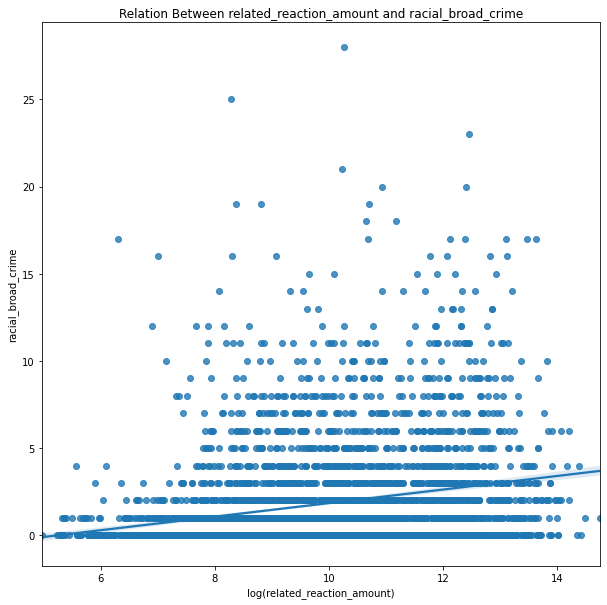

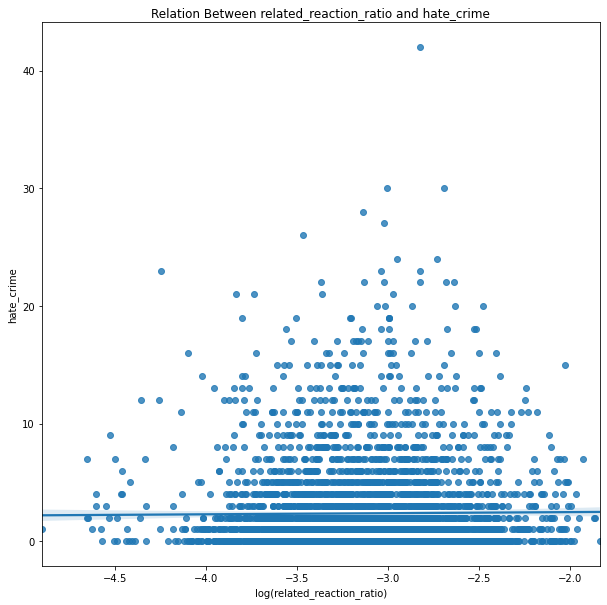

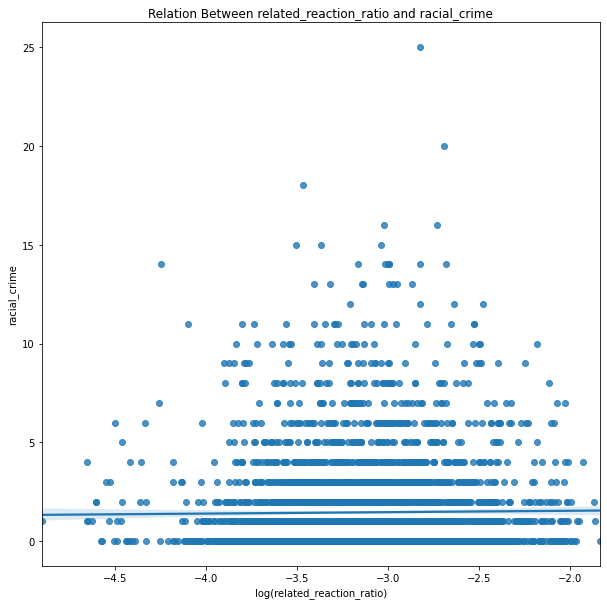

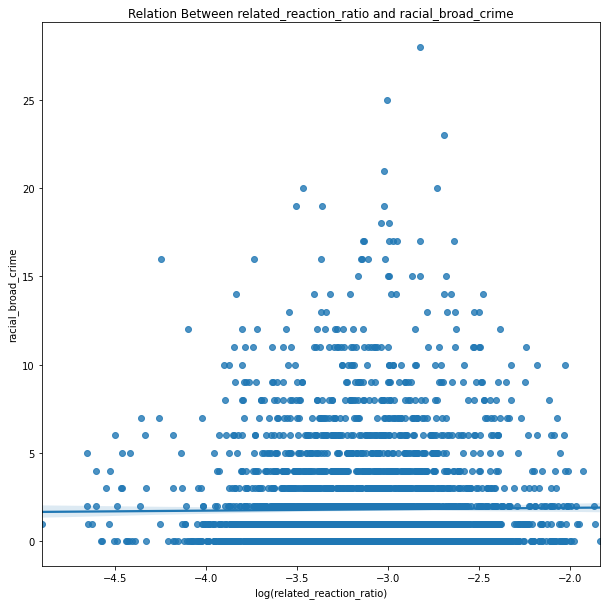

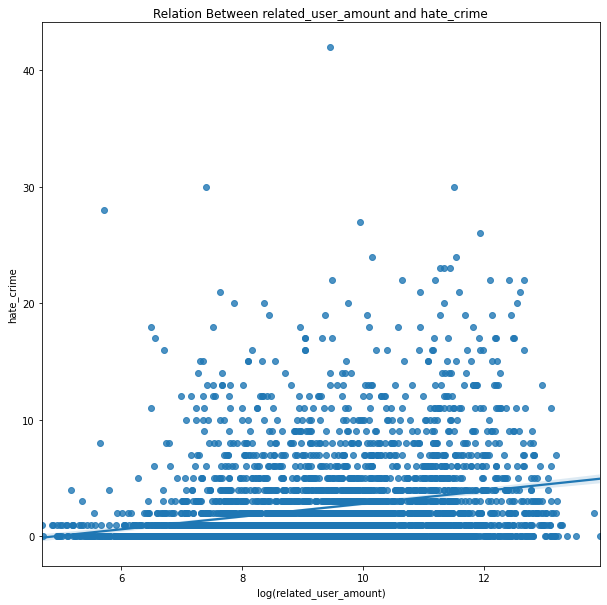

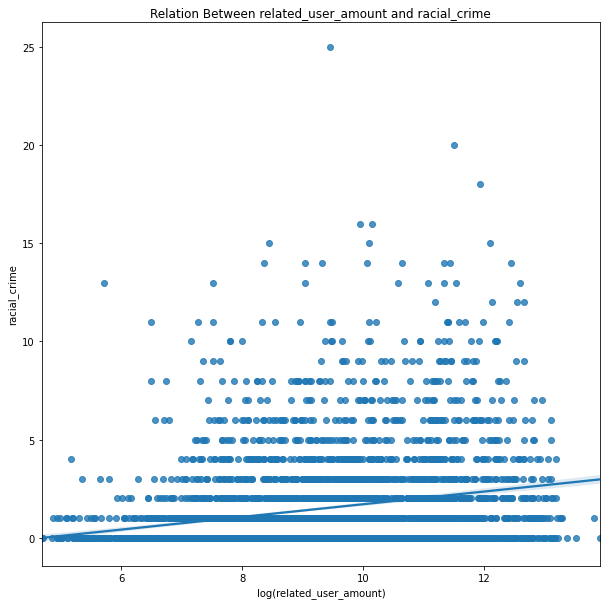

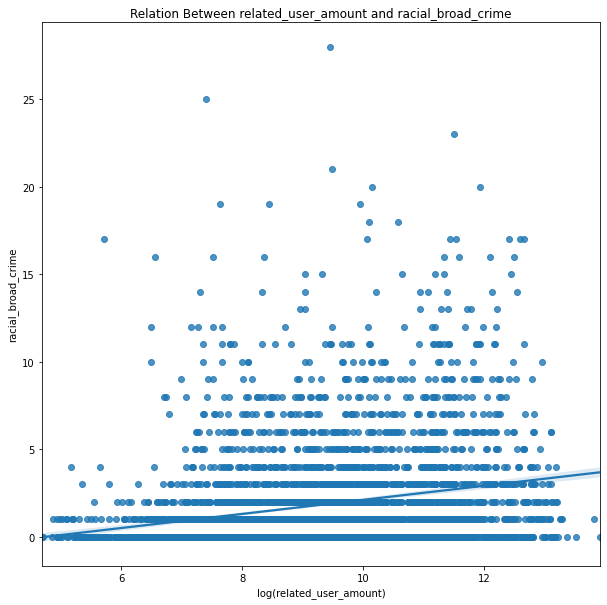

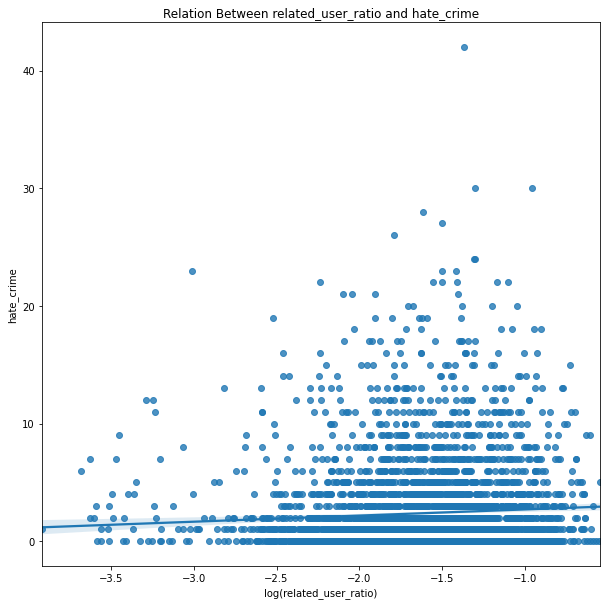

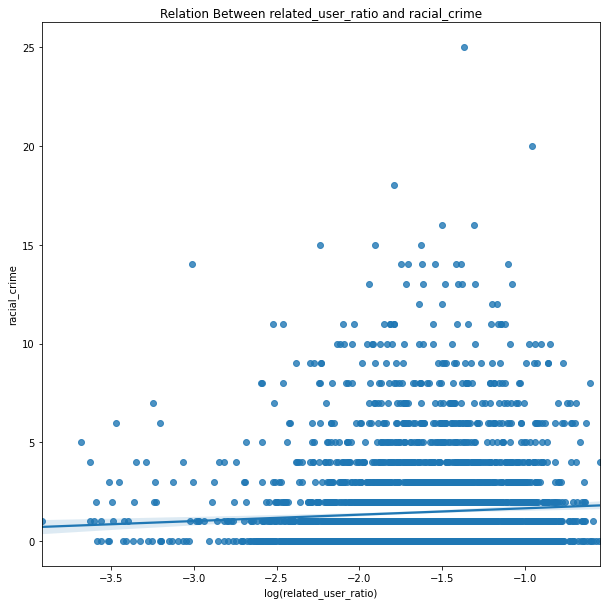

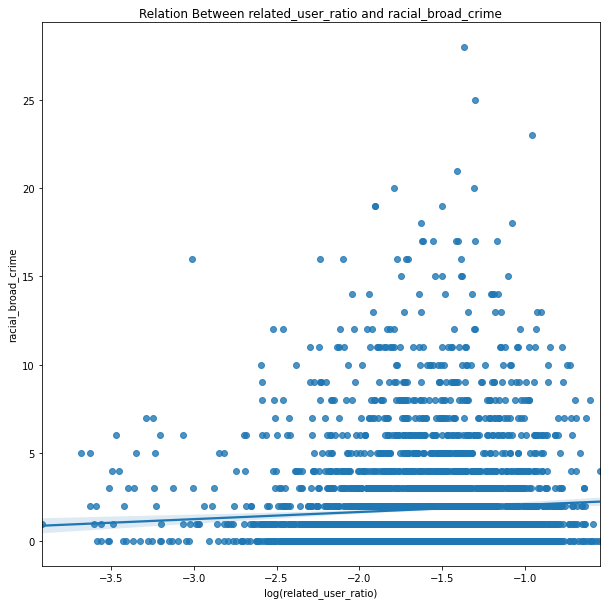

In [51]:
for x in state_df.columns[2:-3].tolist():
    for y in state_df.columns[-3:].tolist():
        plot_relation(state_df, x, y, f'Relation Between {x} and {y}', save_path=f'/home3/r05322021/Desktop/FB_hatecrime/Plot/Hate Crime/{y}/lag/{x}.pdf', y_lag=True, take_log_y=False)

## Save Data

In [44]:
state_df.to_csv('/home3/r05322021/Desktop/FB Data/hate_crime_data/clean_data/immigration_race_regression.csv', index=False)